In [ ]:
import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/ML-Final-Project/AllData/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 4245 images. Here are 5 example filesnames:
['RP-F-00-854.jpg', 'RP-F-00-5161.jpg', 'RP-F-00-9201.jpg', 'RP-F-00-5163.jpg', 'RP-F-00-5162.jpg']


In [ ]:
#************Comment this part after data preparation********************
# Create folder for preprocessed images
import cv2
dirName = '/content/drive/MyDrive/ML-Final-Project/tmp512/'
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists") 
dirName = '/content/drive/MyDrive/ML-Final-Project/tmp512/images/'
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists") 
img_height=512
img_width=512

# Create center-cropped images or resize images
for i in range(len(IMAGES)):
    img = Image.open(PATH + IMAGES[i%len(IMAGES)])
    center = img.size
    if(center[0] > img_height and center[1] > img_width):
      x = center[1]/2 - img_width/2
      y = center[0]/2 - img_height/2
      img = img.crop((int(y), int(x),int(y+img_height),int(x+img_width)))
    else:
      dim = (img_width, img_height)
      # resize image
      # img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
      img = img.resize((img_width, img_height), Image.ANTIALIAS)
    img.save('/content/drive/MyDrive/ML-Final-Project/tmp512/images/'+str(i)+'.png','PNG')
    if i%100000==0: print('created',i,'cropped images')
print('created 5000 cropped images')

Directory  /content/drive/MyDrive/ML-Final-Project/tmp512/  Created 
Directory  /content/drive/MyDrive/ML-Final-Project/tmp512/images/  Created 
created 0 cropped images
created 5000 cropped images


In [ ]:
# build train batches
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

BATCH_SIZE = 150; EPOCHS = 28
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/tmp512/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 4245 images belonging to 1 classes.


In [ ]:
#Autoencoder
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
print(encoded.shape)
# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)
# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

(None, 64, 64, 48)
(None, 32, 32, 48)
(None, 32, 32, 96)
(None, 16, 16, 96)
(None, 16, 16, 192)
(None, 8, 8, 192)
(None, 8, 8, 32)
(None, 8, 8, 192)
(None, 16, 16, 192)
(None, 16, 16, 192)
(None, 32, 32, 192)
(None, 32, 32, 96)
(None, 64, 64, 96)
(None, 64, 64, 48)
(None, 64, 64, 3)


In [ ]:
# Train Process
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

<ipython-input-33-c1fd4f429efe>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_batches,


Epoch 1/28
28/28 - 67s - loss: 0.6370 - 67s/epoch - 2s/step
Epoch 2/28
28/28 - 65s - loss: 0.5724 - 65s/epoch - 2s/step
Epoch 3/28
28/28 - 66s - loss: 0.5607 - 66s/epoch - 2s/step
Epoch 4/28
28/28 - 66s - loss: 0.5577 - 66s/epoch - 2s/step
Epoch 5/28
28/28 - 65s - loss: 0.5558 - 65s/epoch - 2s/step
Epoch 6/28
28/28 - 66s - loss: 0.5539 - 66s/epoch - 2s/step
Epoch 7/28
28/28 - 67s - loss: 0.5537 - 67s/epoch - 2s/step
Epoch 8/28
28/28 - 66s - loss: 0.5523 - 66s/epoch - 2s/step
Epoch 9/28
28/28 - 66s - loss: 0.5520 - 66s/epoch - 2s/step
Epoch 10/28
28/28 - 65s - loss: 0.5510 - 65s/epoch - 2s/step
Epoch 11/28
28/28 - 65s - loss: 0.5521 - 65s/epoch - 2s/step
Epoch 12/28
28/28 - 66s - loss: 0.5506 - 66s/epoch - 2s/step
Epoch 13/28
28/28 - 65s - loss: 0.5511 - 65s/epoch - 2s/step
Epoch 14/28
28/28 - 66s - loss: 0.5504 - 66s/epoch - 2s/step
Epoch 15/28
28/28 - 67s - loss: 0.5497 - 67s/epoch - 2s/step
Epoch 16/28
28/28 - 66s - loss: 0.5497 - 66s/epoch - 2s/step
Epoch 17/28
28/28 - 67s - loss: 0

In [ ]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
args=["/content/drive/MyDrive/ML-Final-Project/Autoencoder/autoencoder_2.h5"]
autoencoder.save(args[0], save_format="h5")

[INFO] saving autoencoder...


1/1 [==============================] - 0s 22ms/step
(1, 8, 8, 32)
(2048,)
(45, 45)
1/1 [==============================] - 0s 27ms/step


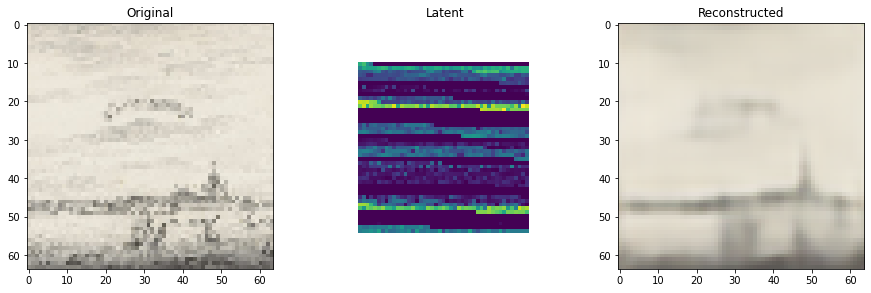

1/1 [==============================] - 0s 21ms/step
(1, 8, 8, 32)
(2048,)
(45, 45)
1/1 [==============================] - 0s 24ms/step


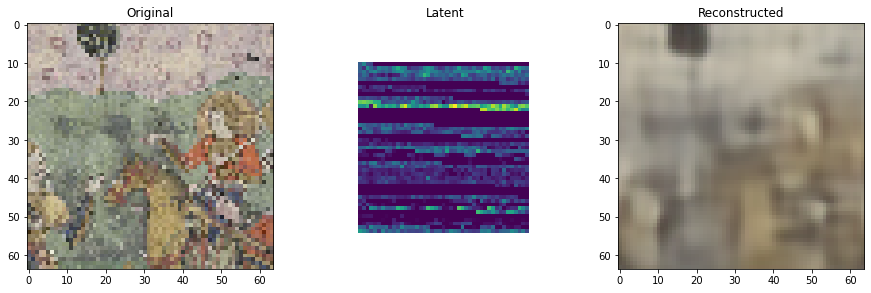

1/1 [==============================] - 0s 22ms/step
(1, 8, 8, 32)
(2048,)
(45, 45)
1/1 [==============================] - 0s 24ms/step


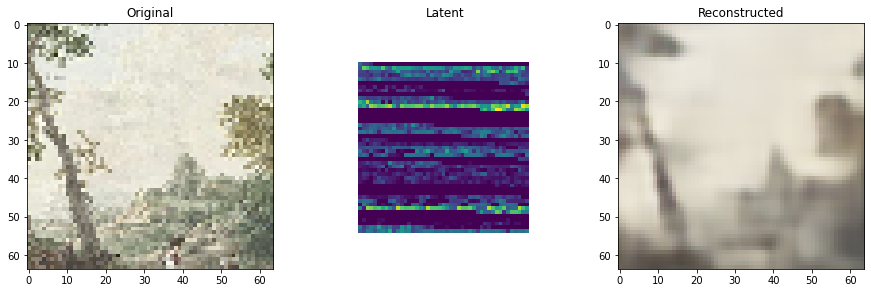

1/1 [==============================] - 0s 21ms/step
(1, 8, 8, 32)
(2048,)
(45, 45)
1/1 [==============================] - 0s 25ms/step


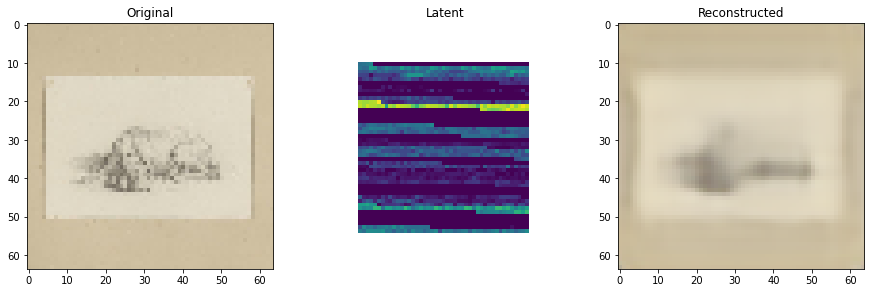

1/1 [==============================] - 0s 23ms/step
(1, 8, 8, 32)
(2048,)
(45, 45)
1/1 [==============================] - 0s 27ms/step


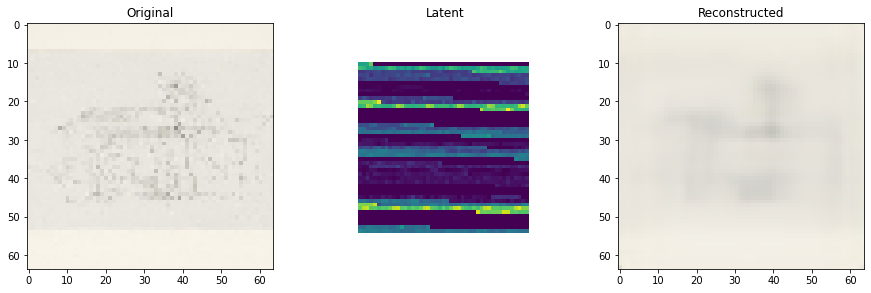

In [ ]:
#plot reconstructed results from autoencoder
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/ML-Final-Project/Autoencoder/autoencoder_2.h5")
images = next(iter(train_batches))[0]
for i in range(5):
    plt.figure(figsize=(15,5))
    # Original IMAGE
    plt.subplot(1,3,1)
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)
    img.save('/content/drive/MyDrive/ML-Final-Project/Autoencoder/'+str(i)+'ori_all64-7.png','PNG')
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    print(latent_img.shape)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    print(latent_flat.shape)
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    print(img.size)
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)
    img.save('/content/drive/MyDrive/ML-Final-Project/Autoencoder/'+str(i)+'latent_all64-7.png','PNG')
    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    plt.show()
    img.save('/content/drive/MyDrive/ML-Final-Project/Autoencoder/'+str(i)+'reconstruct_all64-7.png','PNG')

In [ ]:
#************Comment this part after data preparation********************
# preprocess the images for each category
PATH = '/content/drive/MyDrive/ML-Final-Project/whole-1000/photomechanical print/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])
# preprocess the images for each category
import cv2
dirName = '/content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/'
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists") 
dirName = '/content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/images/'
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists") 

img_height=512
img_width=512

# Create center-cropped images or resize images
for i in range(len(IMAGES)):
    img = Image.open(PATH + IMAGES[i%len(IMAGES)])
    center = img.size
    if(center[0] > img_height and center[1] > img_width):
      x = center[1]/2 - img_width/2
      y = center[0]/2 - img_height/2
      img = img.crop((int(y), int(x),int(y+img_height),int(x+img_width)))
    else:
      dim = (img_width, img_height)
      # resize image
      # img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
      img = img.resize((img_width, img_height), Image.ANTIALIAS)
    img.save('/content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/images/'+str(i)+'.png','PNG')
    if i%100000==0: print('created',i,'cropped images')
print(f"created {len(IMAGES)} cropped images")

Directory  /content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/  Created 
Directory  /content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/images/  Created 
created 0 cropped images
created 1011 cropped images


In [ ]:
# PCA/SVD section - for painting & photomechanical print
import numpy
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
model=load_model("/content/drive/MyDrive/ML-Final-Project/Autoencoder/autoencoder_2.h5")
BATCH_SIZE = 1000; 
image_samples = 1000
rows, cols = (2*image_samples, 2048)
latent_matrix = []

# Add Painting latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/PaintingPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))
# Add PhotoMechanicalPrint latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))


Found 1013 images belonging to 1 classes.
1/1 [==============================] - 0s 25ms/step
Found 1011 images belonging to 1 classes.
1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, '')

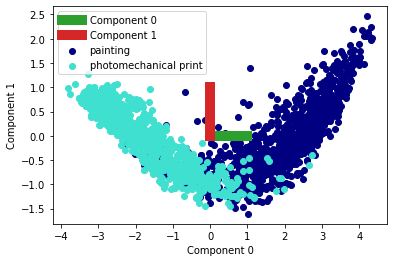

In [ ]:
# PCA/SVD section - cluserting plot - for painting & photomechanical print
from numpy import linalg as LA
temp = numpy.array(latent_matrix)
temp = temp.reshape(2*image_samples, 2048)
pca = PCA(n_components=2)
key_features = pca.fit(temp)
latent_transformed = pca.fit(temp).transform(temp)

plt.figure()
for i in range(999):
  plt.scatter(latent_transformed[i][0], latent_transformed[i][1],color = "navy")
for i in range(999):
  plt.scatter(latent_transformed[i+1000][0], latent_transformed[i+1000][1], color = "turquoise")
# add legend
i = 999
plt.scatter(latent_transformed[i][0], latent_transformed[i][1],color = "navy",label="painting")
plt.scatter(latent_transformed[i+1000][0], latent_transformed[i+1000][1], color = "turquoise",label = "photomechanical print")
i = 0
plt.plot([0, 1],[0, 0],
        label=f"Component {i}",
        linewidth=10,
        color=f"C{i + 2}",)
i = 1
plt.plot([0, 0],[0, 1],
        label=f"Component {i}",
        linewidth=10,
        color=f"C{i + 2}",)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.gca().set(
    title="2-dimensional principal components of dataset",
    xlabel="Component 0",
    ylabel="Component 1",
)
plt.title("")

(2048,)
1/1 [==============================] - 0s 26ms/step


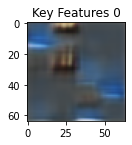

(2048,)
1/1 [==============================] - 0s 29ms/step


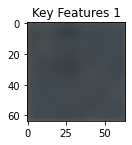

In [ ]:
# PCA/SVD section - visualizing key features for art type - for painting & photomechanical print
for i, (comp, var) in enumerate(zip(key_features.components_, key_features.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    print(comp.shape)
    decoded_imgs = decoder.predict(comp.reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title(f"Key Features {i}")
    plt.imshow(img)
    img.save('/content/drive/MyDrive/ML-Final-Project/Autoencoder/'+str(i)+'features-4_painting_photoprint.png','PNG')
    plt.show()

In [ ]:
# PCA/SVD section - All 4 art types
import numpy
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
model=load_model("/content/drive/MyDrive/ML-Final-Project/Autoencoder/autoencoder_2.h5")
BATCH_SIZE = 1000; 
image_samples = 1000
rows, cols = (4*image_samples, 2048)
latent_matrix = []
# Add photograph latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/photographPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))
# Add Painting latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/PaintingPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))
# Add PhotoMechanicalPrint latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/PhotoMechanicalPrintPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))
# Add drawing latent vectors to latent matrix
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/ML-Final-Project/drawingPCA/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)
images = next(iter(train_batches))[0]
for i in range(image_samples):
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat_normalized = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    latent_flat = (latent_img[0]).flatten(order='F')
    latent_matrix.append(numpy.array(latent_flat))

Found 1210 images belonging to 1 classes.
1/1 [==============================] - 0s 21ms/step
Found 1013 images belonging to 1 classes.
1/1 [==============================] - 0s 22ms/step
Found 1011 images belonging to 1 classes.
1/1 [==============================] - 0s 24ms/step
Found 1012 images belonging to 1 classes.
1/1 [==============================] - 0s 23ms/step


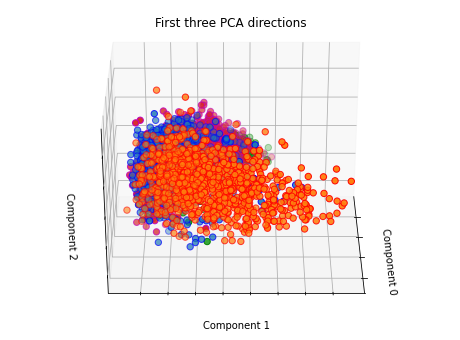

In [ ]:
# PCA/SVD section - cluserting plot - All 4 art types
# !pip install PyQt5
# %matplotlib qt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation
from numpy import linalg as LA

temp = numpy.array(latent_matrix)
temp = temp.reshape(4*image_samples, 2048)
pca = PCA(n_components=3)
key_features = pca.fit(temp)
latent_transformed = pca.fit(temp).transform(temp)

def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

# To get a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))

ax = fig.add_subplot(111, projection="3d", elev=-120, azim=60)
ax.scatter(
    latent_transformed[0:999, 0],
    latent_transformed[0:999, 1],
    latent_transformed[0:999, 2],
    cmap=plt.cm.Set1,
    edgecolor="b",
    s=40,
)
ax.scatter(
    latent_transformed[1000:1999, 0],
    latent_transformed[1000:1999, 1],
    latent_transformed[1000:1999, 2],
    cmap=plt.cm.Set1,
    edgecolor="r",
    s=40,
)
ax.scatter(
    latent_transformed[2000:2999, 0],
    latent_transformed[2000:2999, 1],
    latent_transformed[2000:2999, 2],
    cmap=plt.cm.Set1,
    edgecolor="g",
    s=40,
)
ax.scatter(
    latent_transformed[3000:3999, 0],
    latent_transformed[3000:3999, 1],
    latent_transformed[3000:3999, 2],
    cmap=plt.cm.Set1,
    edgecolor="m",
    s=40,
)
ax.scatter(
    latent_transformed[3999, 0],
    latent_transformed[3999, 1],
    latent_transformed[3999, 2],
    cmap=plt.cm.Set1,
    edgecolor="m",
    s=40,
    label = "drawing",
)
# i = 0
# plt.plot([0, 1],[0, 0],[0,0],
#         label=f"Component {i}",
#         linewidth=10,
#         color=f"C{i + 2}",)
# i = 1
# plt.plot([0, 0],[0, 1],[0,0],
#         label=f"Component {i}",
#         linewidth=10,
#         color=f"C{i + 2}",)
# i = 2
# plt.plot([0, 0],[0, 0],[0,1],
#         label=f"Component {i}",
#         linewidth=10,
#         color=f"C{i + 2}",)
ax.set_title("First three PCA directions")
ax.set_xlabel("Component 0")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Component 1")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("Component 2")
ax.zaxis.set_ticklabels([])

anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
HTML(anim.to_html5_video())

1/1 [==============================] - 0s 30ms/step


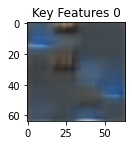

1/1 [==============================] - 0s 25ms/step


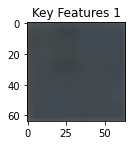

1/1 [==============================] - 0s 27ms/step


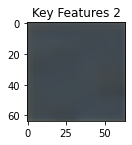

In [ ]:
# PCA/SVD section - visualizing key features for art type - All 4 art types
for i, (comp, var) in enumerate(zip(key_features.components_, key_features.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    # print(comp.shape)
    decoded_imgs = decoder.predict(comp.reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title(f"Key Features {i}")
    plt.imshow(img)
    img.save('/content/drive/MyDrive/ML-Final-Project/Autoencoder/'+str(i)+'features-4_all4types.png','PNG')
    plt.show()